# Convergence Benchmarks

In [3]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Fit SPAM model

### Generate True Model, Full POVM and Inital

In [4]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n

    init_target = InitialState(d, c=c1)
    povm_target = POVM(d, c=c2)

    spam_target = SPAM(init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, noise=0):
    n = int(np.log2(spam_target.d))
    inputs_spam, _ = generate_pauliInput_circuits(n)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init.init[None,:,:], N_spam, axis=0)
    state = apply_unitary(state, inputs_spam)
    targets_spam = measurement(state, povm = spam_target.povm.povm)

    #add noise
    targets_spam = add_noise_to_probs(targets_spam, noise=noise)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, noise=0):
    n = channel_target.n
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm.povm)
    
    return inputs_map, targets_map


def povm_fidelity(povm_a, povm_b):
    d = povm_a.shape[0]
    ab = tf.matmul(povm_a, povm_b)
    ab_sqrt = tf.linalg.sqrtm(ab)
    fidelity = tf.math.reduce_sum(tf.linalg.trace(ab_sqrt))/d
    return fidelity


## Three Qubit

In [35]:
n = 3
d = 2**n
c1 = 0.8
c2 = 0.8

num_reps = 5
noise_list = np.logspace(-1, -3, 10)
noise_list = np.append(noise_list, 0)

init_3q_corr = np.zeros((len(noise_list), num_reps))
povm_3q_corr = np.zeros((len(noise_list), num_reps))

for i, noise in tqdm(enumerate(noise_list)):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    for rep in range(num_reps):
        spam_target = generate_spam_benchmark(n=n, c1=c1, c2=c2)
        inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

        spam_model = SPAM(init = InitialState(d, c=None),
                          povm = CorruptionMatrix(d, c=None),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01))
        
        spam_model.pretrain(num_iter = 300,
                         verbose = False,
                        )

        spam_model.train(inputs = inputs_spam,
                         targets = targets_spam,
                         num_iter = 2000,
                         verbose = False,
                        )
        
        init_3q_corr[i, rep] = state_fidelity(spam_model.init.init, spam_target.init.init)
        povm_3q_corr[i, rep] = povm_fidelity(spam_model.povm.povm, spam_target.povm.povm)
        
saver(init_3q_corr, "init_3q_corr.p")
saver(povm_3q_corr, "povm_3q_corr.p")

0it [00:00, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006719409640398298


C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\tensorflow\python\framework\ops.py:1064: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006964837808866237


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.007276358253733011


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006973946643238959


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006585333950096413


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00250562405953989


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002637210598282621


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0027406088892196197


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0025863562561372778


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0024752943677397265


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010390188215474408


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.001156822682757803


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0011235443064500797


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010565246041065771


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.001029562064269571


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.000516388552467001


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0005393907559154472


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.000539400912399002


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0005110713863727951


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0005014770849016915


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00032806613096543133


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0003397545872731898


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00032857759249969415


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00031385186476252653


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00031051143606214106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002589358266951535


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.000266896979608588


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00025041312213778833


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00024182485063703682


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00024013409128078352


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00023372726034538336


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002420038725910511


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00022121866278440838


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00021551019093272357


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00021380519089574603


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002243476428641439


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.000230083948757814


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00021006902514324118


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00020518304724869061


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00020372969395729355


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00022078434823936046


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002262606889045836


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00020564967047616964


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00020130726293206684


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00019973223297070213


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00021938812886302124


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002247505699428481


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002038142953525082


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00019974957180423736


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0001980691756033989


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00021833543502122973


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00022358947129651525


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00020220735539628007


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00019928457804868852


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0001966234982726516


In [36]:
n = 3
d = 2**n
c1 = 0.8
c2 = 0.8

num_reps = 5
noise_list = np.logspace(-1, -3, 10)
noise_list= np.append(noise_list, 0)

init_3q_corr = np.zeros((len(noise_list), num_reps))
povm_3q_corr = np.zeros((len(noise_list), num_reps))

for i, noise in tqdm(enumerate(noise_list)):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    for rep in range(num_reps):
        spam_target = generate_spam_benchmark(n=n, c1=c1, c2=c2)
        inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

        spam_model = SPAM(init = InitialState(d, c=None),
                          povm = POVM(d, c=None),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01))
        
        spam_model.pretrain(num_iter = 300,
                         verbose = False,
                        )

        spam_model.train(inputs = inputs_spam,
                         targets = targets_spam,
                         num_iter = 2000,
                         verbose = False,
                        )
        
        init_3q_corr[i, rep] = state_fidelity(spam_model.init.init, spam_target.init.init)
        povm_3q_corr[i, rep] = povm_fidelity(spam_model.povm.povm, spam_target.povm.povm)
        
saver(init_3q_corr, "init_3q_povm.p")
saver(povm_3q_corr, "povm_3q_povm.p")

0it [00:00, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0051098638986205635


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.005043893835881581


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0049593329597805436


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00522817916644825


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00522319456520096


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0017481897379573782


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0017039642553850613


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0017094380161883772


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.001817695302224616


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0017900333337455348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.000611913101278013


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0005893009876231889


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0005957570473165825


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0006419188631680895


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0006311504504912673


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00022019421987203377


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002077370620311082


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002097184066697481


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0002292349504695977


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00022447109512939244


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.077263731951778e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.438597145512556e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.519308291093884e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.198053611899554e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.121155081699684e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2.837921951332547e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2.69892887914782e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2.7199635357325964e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2.9870561264824724e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2.9581596179228635e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.0817986306907662e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

9.896520837827756e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

9.926215274139734e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.1645454137781484e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.0782785231630763e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.7820993252401967e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.6491034768299007e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.6732003595394185e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4.191215573583654e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4.0210532496565594e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.4174944942029916e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.4013534400720562e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.4294411049852997e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.7116217045279904e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.5645747970254298e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5.77896282555399e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2.6695741191435205e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.795926337250935e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.237389822112263e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.66997022848016e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

9.168734560038922e-08


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.3051250828291992e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.7496588346223437e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.176995374350514e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.6909469862051747e-07


## Four Qubit

In [37]:
n = 4
d = 2**n
c1 = 0.8
c2 = 0.8

num_reps = 5
noise_list = np.logspace(-1, -3, 10)
noise_list = np.append(noise_list, 0)

init_4q_corr = np.zeros((len(noise_list), num_reps))
povm_4q_corr = np.zeros((len(noise_list), num_reps))

for i, noise in tqdm(enumerate(noise_list)):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    for rep in range(num_reps):
        spam_target = generate_spam_benchmark(n=n, c1=c1, c2=c2)
        inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

        spam_model = SPAM(init = InitialState(d, c=None),
                          povm = CorruptionMatrix(d, c=None),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01))
        
        spam_model.pretrain(num_iter = 300,
                         verbose = False,
                        )

        spam_model.train(inputs = inputs_spam,
                         targets = targets_spam,
                         num_iter = 2000,
                         verbose = False,
                        )
        
        init_4q_corr[i, rep] = state_fidelity(spam_model.init.init, spam_target.init.init)
        povm_4q_corr[i, rep] = povm_fidelity(spam_model.povm.povm, spam_target.povm.povm)
        
saver(init_4q_corr, "init_4q_corr.p")
saver(povm_4q_corr, "povm_4q_corr.p")

0it [00:00, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.008087839059420173


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.008130035155081473


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.008279362712986356


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.008000938550879822


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00788990614289912


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002898391747610071


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002896259201744105


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0029662359248940587


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0028606710707856304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002824354412742409


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010860214746682942


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010835609042125164


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0011052801844755882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010593381078581386


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0010533862524705916


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00044130505821019097


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00043425072861669103


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0004428814260336902


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0004216757195723106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0004199602749665551


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00021016034876626428


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00020290922826020995


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00020574567459404812


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00019430470812574114


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0001947531587863451


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00012688958533319303


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00012074189847067349


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00011974231581481297


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00011277839703072836


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00011197393691272925


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

9.676494773003902e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

9.564900666997178e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.88742488362e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.396963886999408e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.57145395472854e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.580745169020916e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.111685945557205e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.769835465346019e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.369405263809347e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.355326117153482e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.177795763320079e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.747883141001185e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.361846107556099e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.00416169584153e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.932290250878338e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.03186658067544e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.620499771050646e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.212647679523258e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.864567655738522e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.81070704042869e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.936653758671199e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.566438756641603e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.123026577204532e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.80837646234628e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.74779800750248e-05


In [38]:
n = 4
d = 2**n
c1 = 0.8
c2 = 0.8

num_reps = 5
noise_list = np.logspace(-1, -3, 10)
noise_list = np.append(noise_list, 0)

init_4q_povm = np.zeros((len(noise_list), num_reps))
povm_4q_povm = np.zeros((len(noise_list), num_reps))

for i, noise in tqdm(enumerate(noise_list)):
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    for rep in range(num_reps):
        spam_target = generate_spam_benchmark(n=n, c1=c1, c2=c2)
        inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

        spam_model = SPAM(init = InitialState(d, c=None),
                          povm = POVM(d, c=None),
                          optimizer = tf.optimizers.Adam(learning_rate=0.01))
        
        spam_model.pretrain(num_iter = 300,
                         verbose = False,
                        )

        spam_model.train(inputs = inputs_spam,
                         targets = targets_spam,
                         num_iter = 2000,
                         verbose = False,
                        )
        
        init_4q_povm[i, rep] = state_fidelity(spam_model.init.init, spam_target.init.init)
        povm_4q_povm[i, rep] = povm_fidelity(spam_model.povm.povm, spam_target.povm.povm)
        
saver(init_4q_povm, "init_4q_povm.p")
saver(povm_4q_povm, "povm_4q_povm.p")

0it [00:00, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006986776734394732


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.007056321583235712


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006825098656856107


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.007050566992832033


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.006999463143215879


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002395809882982156


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00243078402870122


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00234463977715925


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0024296624756120024


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.002400776792867272


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0008369085065833231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0008525729578035144


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0008196777996694463


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0008514974529967938


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0008392308531654484


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00029641624655868203


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0003026166646240248


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00029026055081532356


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0003020917970283473


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00029904828897485837


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00010579819500890995


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00010829563738072264


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00010372778713868059


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0001080540789853974


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0.00010666604436706548


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.795000872240344e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.889376169348902e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.736017458801684e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

3.882518501258883e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4.132161413673342e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.367022422144293e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.3997083704153362e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.340167395929404e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.4011224672329977e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.3763726295148244e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4.950937463580683e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5.058534879104781e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4.839400924551395e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5.0625183996671856e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.4104316566302292e-05


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.8139627599188404e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2.109397482934025e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.7838750165048359e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.8580742010003318e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

1.8220605129605212e-06


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

8.558145617517113e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.940281065482658e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.602039978502472e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

7.056901275663991e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

6.917494861713315e-07


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4.8109710942424017e-08


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5.812398756825402e-08


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

4.029377149731589e-08


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5.8764216794579094e-08


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

5.4003862459461714e-08


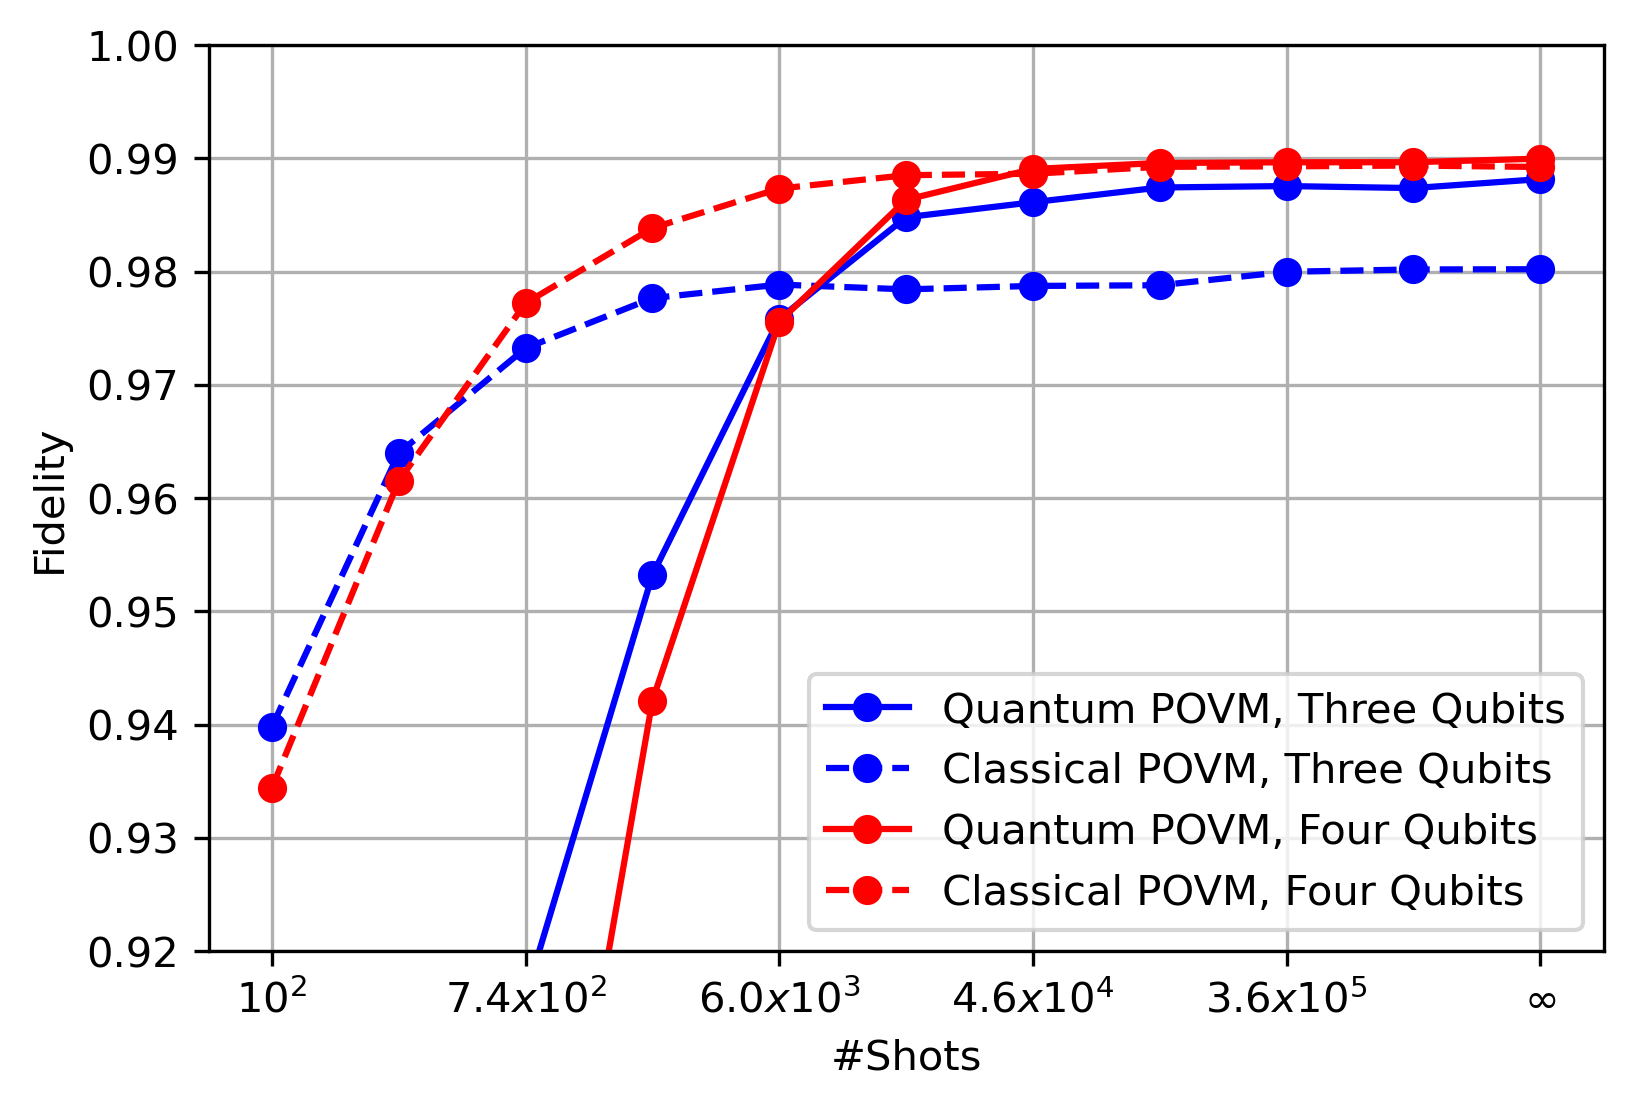

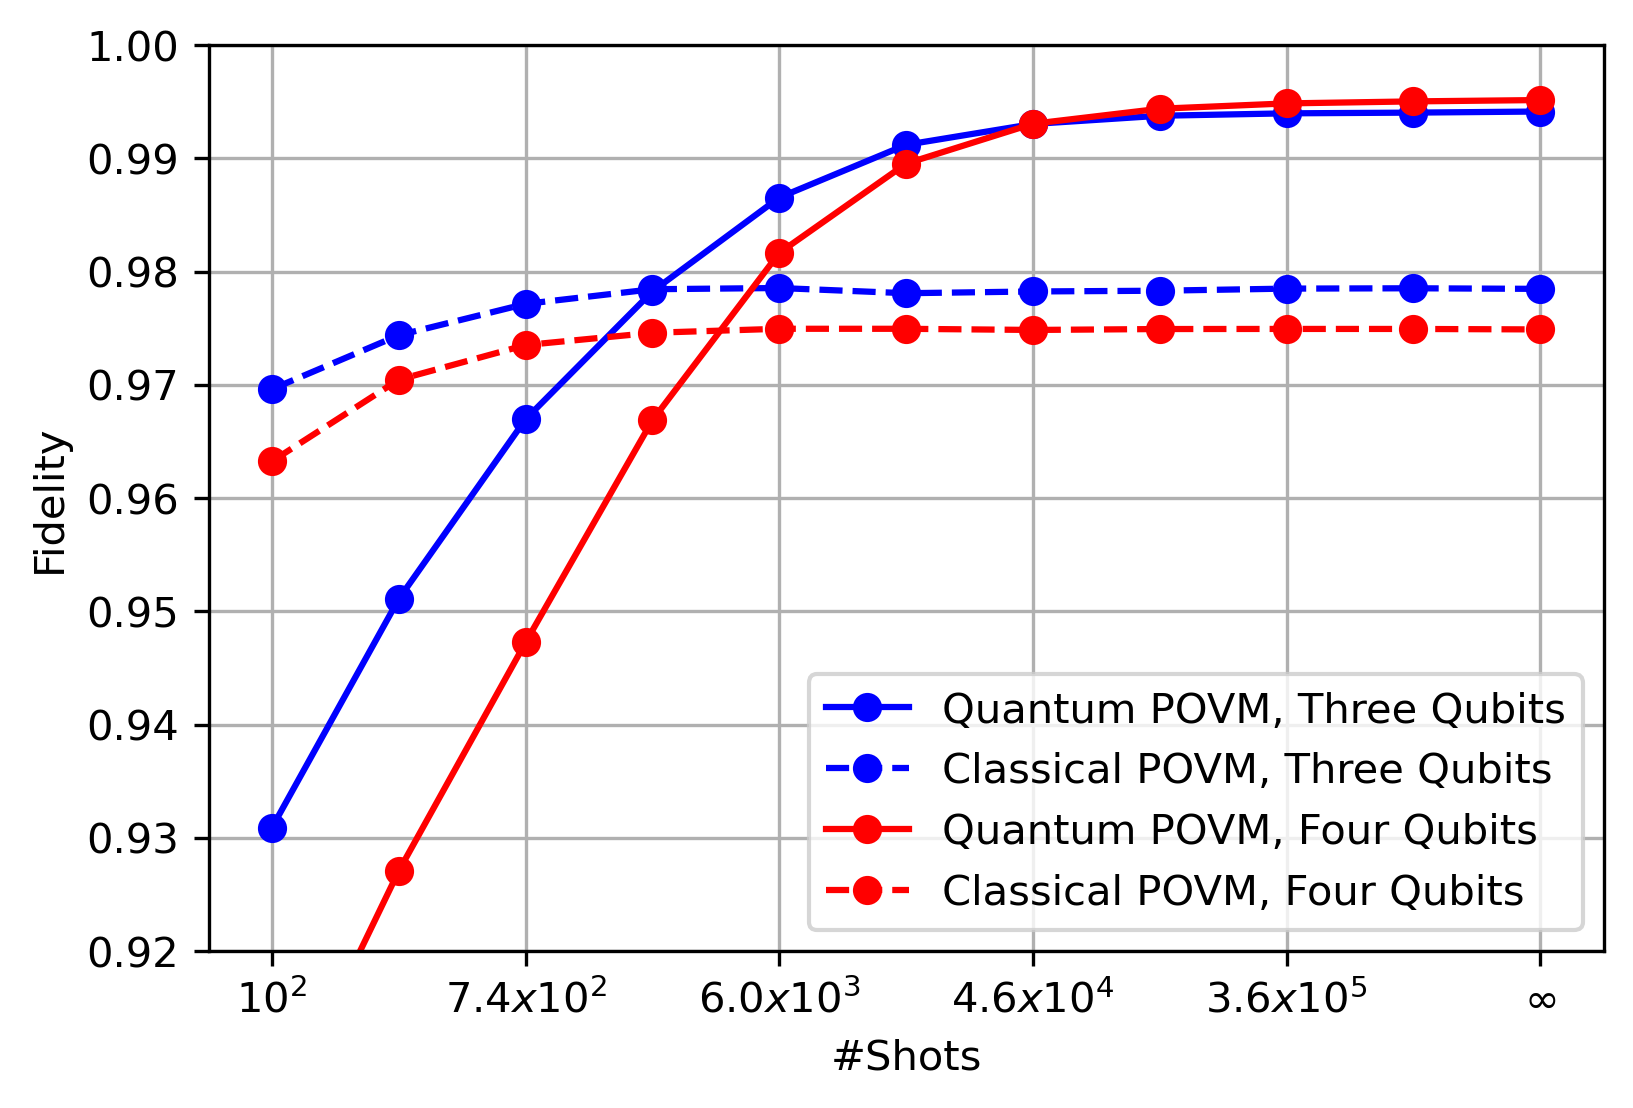

In [39]:
init_3q_corr = loader("init_3q_corr.p")
init_3q_povm = loader("init_3q_povm.p")

povm_3q_corr = loader("povm_3q_corr.p")
povm_3q_povm = loader("povm_3q_povm.p")

init_4q_corr = loader("init_4q_corr.p")
init_4q_povm = loader("init_4q_povm.p")

povm_4q_corr = loader("povm_4q_corr.p")
povm_4q_povm = loader("povm_4q_povm.p")


shots_list = list(1/noise_list[:-1]**2)

init_3q_corr_avg = np.mean(init_3q_corr, axis=1)
init_3q_povm_avg = np.mean(init_3q_povm, axis=1)

init_4q_corr_avg = np.mean(init_4q_corr, axis=1)
init_4q_povm_avg = np.mean(init_4q_povm, axis=1)

povm_3q_corr_avg = np.mean(povm_3q_corr, axis=1)
povm_3q_povm_avg = np.mean(povm_3q_povm, axis=1)

povm_4q_corr_avg = np.mean(povm_4q_corr, axis=1)
povm_4q_povm_avg = np.mean(povm_4q_povm, axis=1)

x_list = [0,1,2,3,4,5,6,7,8,9,10]
ticks_list = [0,2,4,6,8,10]
labels = ["$10^2$", "$7.4 x 10^2$", "$6.0 x 10^3$", "$4.6 x 10^4$", "$3.6 x 10^5$","$\infty$"]

fig = plt.figure(figsize=(6, 4), dpi=300, facecolor="w", edgecolor="k")
plt.plot(x_list, init_3q_povm_avg, "bo-")
plt.plot(x_list, init_3q_corr_avg, "bo--")

plt.plot(x_list, init_4q_povm_avg, "ro-")
plt.plot(x_list, init_4q_corr_avg, "ro--")

plt.xticks(ticks_list, labels)
plt.ylim([0.92, 1])

plt.xlabel("#Shots")
plt.ylabel("Fidelity")
plt.legend(["Quantum POVM, Three Qubits", "Classical POVM, Three Qubits", 
           "Quantum POVM, Four Qubits", "Classical POVM, Four Qubits",])


plt.grid()
plt.savefig("SPAM_recovery_shots_sensitivy_init.pdf")
plt.show()


fig = plt.figure(figsize=(6, 4), dpi=300, facecolor="w", edgecolor="k")
plt.plot(x_list, povm_3q_povm_avg, "bo-")
plt.plot(x_list, povm_3q_corr_avg, "bo--")

plt.plot(x_list, povm_4q_povm_avg, "ro-")
plt.plot(x_list, povm_4q_corr_avg, "ro--")

plt.xticks(ticks_list, labels)
plt.ylim([0.92, 1])

plt.xlabel("#Shots")
plt.ylabel("Fidelity")
plt.legend(["Quantum POVM, Three Qubits", "Classical POVM, Three Qubits", 
           "Quantum POVM, Four Qubits", "Classical POVM, Four Qubits",])


plt.grid()
plt.savefig("SPAM_recovery_shots_sensitivy_povm.pdf")
plt.show()

In [7]:
np.random.randint(0, 10**6)

78218

In [5]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 4
d = 2**n

spam_target = generate_spam_benchmark(n=n, c1=0.8, c2=0.8)
inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=1/2**5)

spam_model = SPAM(init = InitialState(d, c=None),
                  povm = CorruptionMatrix(d, c=None),
                  optimizer = tf.optimizers.Adam(learning_rate=0.01))

spam_model.pretrain(num_iter = 300,
                 verbose = False,
                )

spam_model.train(inputs = inputs_spam,
                 targets = targets_spam,
                 num_iter = 2000,
                 verbose = True,
                )

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0 0.015368814799361042
1 0.010402953742707468
2 0.007346241222062503
3 0.005222911683786963
4 0.0037308941749446423
5 0.0026930705567500784
6 0.001960649307621371
7 0.0015410850921542508
8 0.0013550142263532535
9 0.0013186566897070474
10 0.001373242993255425
11 0.0014748126319227208
12 0.0015909735262707892
13 0.0017019575989023188
14 0.0017951543919594536
15 0.001864497727152914
16 0.0019075451929178437
17 0.0019245311702690124
18 0.001917876267033669
19 0.0018914439110467125
20 0.0018482535782417637
21 0.0017928825023173758
22 0.0017291012437707725
23 0.0016606115234446253
24 0.0015907506930007123
25 0.0015224469034388652
26 0.0014581329077392356
27 0.0013998874847475904
28 0.0013491520382690962
29 0.001306456287055356
30 0.0012720669627162
31 0.001245625022838168
32 0.001226511747096355
33 0.0012132523659791321
34 0.0012052297666965948
35 0.001201236175214051
36 0.0012000224474015002
37 0.001200371789045999
38 0.0012012445123858971
39 0.0012016561572393096
40 0.0012009187552717159
4

323 0.0008555331647411108
324 0.0008554390012402293
325 0.0008553458855667965
326 0.0008552538117450569
327 0.0008551627552397574
328 0.0008550726770337531
329 0.0008549835303443327
330 0.0008548952701031638
331 0.0008548078634087519
332 0.0008547212969097294
333 0.0008546355777383092
334 0.0008545507271597447
335 0.0008544667689336304
336 0.0008543837170956896
337 0.0008543015685747648
338 0.0008542203027614492
339 0.0008541398856879457
340 0.0008540602761513659
341 0.0008539814341047098
342 0.0008539033313852411
343 0.0008538259600129487
344 0.0008537493314064762
345 0.0008536734658960045
346 0.0008535983795348874
347 0.0008535240755008657
348 0.0008534505415364625
349 0.0008533777512634028
350 0.00085330566856757
351 0.0008532342555303734
352 0.0008531634823030015
353 0.0008530933348602687
354 0.00085302381703394
355 0.0008529549458649928
356 0.000852886742178781
357 0.0008528192204703487
358 0.0008527523823477737
359 0.0008526862150905342
360 0.000852620693976097
361 0.000852555787

640 0.0008450319273759221
641 0.0008450183746481193
642 0.0008450048394704426
643 0.0008449913314987147
644 0.0008449778498098814
645 0.0008449643816318157
646 0.0008449509076317747
647 0.0008449374136947148
648 0.0008449239001877684
649 0.0008449103805756563
650 0.0008448968721676137
651 0.0008448833874601663
652 0.0008448699293260233
653 0.0008448564887903499
654 0.0008448430475144308
655 0.0008448295880052134
656 0.0008448161056076662
657 0.0008448026110081849
658 0.0008447891218551728
659 0.0008447756529602332
660 0.0008447622106928239
661 0.0008447487897043644
662 0.0008447353733017912
663 0.0008447219421892463
664 0.0008447084877105796
665 0.000844695017568937
666 0.0008446815492963539
667 0.0008446680995066842
668 0.0008446546770896048
669 0.0008446412798395727
670 0.0008446278934648406
671 0.0008446144977992315
672 0.0008446010804189627
673 0.0008445876458210817
674 0.0008445742108754387
675 0.0008445607933351832
676 0.0008445474042311715
677 0.0008445340441545298
678 0.0008445

958 0.0008418461908844117
959 0.0008418422459200529
960 0.0008418378248604092
961 0.0008418323780736525
962 0.0008418278325874237
963 0.0008418240894780347
964 0.000841819631081326
965 0.0008418152885066204
966 0.000841812142206485
967 0.0008418084429180426
968 0.0008418034621036837
969 0.0008417993788576152
970 0.0008417963945565404
971 0.0008417927956505917
972 0.0008417890017689127
973 0.0008417866150648187
974 0.0008417837927209679
975 0.0008417794537407939
976 0.0008417759910485284
977 0.0008417740869566328
978 0.0008417712234397154
979 0.0008417680143035798
980 0.0008417668199879885
981 0.0008417652834567807
982 0.000841761790130516
983 0.0008417591711657321
984 0.0008417585014253951
985 0.0008417568511603853
986 0.0008417545803338401
987 0.0008417546263250533
988 0.0008417544898863727
989 0.0008417519801950071
990 0.000841750513132068
991 0.0008417514786244781
992 0.0008417509134624163
993 0.0008417497155812438
994 0.000841751570535354
995 0.0008417533785293067
996 0.00084175179

1265 0.0008410830503981959
1266 0.0008411103901564682
1267 0.0008410828543903147
1268 0.0008410955932901957
1269 0.0008410847995703738
1270 0.0008410960348202497
1271 0.0008410726021554575
1272 0.0008411131720642483
1273 0.0008410690491728713
1274 0.0008411101745768277
1275 0.000841076023795137
1276 0.000841099170985293
1277 0.0008410700548307199
1278 0.0008410942971480334
1279 0.0008410396384989747
1280 0.0008410801544641087
1281 0.0008410141885818309
1282 0.0008410437795493481
1283 0.0008410483983913905
1284 0.0008410526716982396
1285 0.0008410817542935308
1286 0.0008410845677036727
1287 0.0008411234775615211
1288 0.0008411144402880561
1289 0.0008412053270396041
1290 0.0008412359383851794
1291 0.0008415480985591778
1292 0.0008415692866787336
1293 0.00084232459618529
1294 0.0008422290986844781
1295 0.0008435224610585473
1296 0.0008432617565390973
1297 0.0008439768000223348
1298 0.0008460149508859064
1299 0.000842768320797212
1300 0.000845658924043242
1301 0.0008470807026256042
1302 0.

1570 0.0008404415735025826
1571 0.0008404428172389206
1572 0.0008404427170474213
1573 0.0008404428869709264
1574 0.0008404437211691045
1575 0.0008404439766555021
1576 0.0008404451122302082
1577 0.0008404468862764824
1578 0.0008404476017209882
1579 0.0008404485387718536
1580 0.0008404500080456815
1581 0.0008404506040454023
1582 0.0008404518349105293
1583 0.0008404539053433413
1584 0.0008404545677394115
1585 0.0008404553622584733
1586 0.0008404564901352152
1587 0.00084045700416403
1588 0.0008404586193947723
1589 0.0008404612796986865
1590 0.0008404630377958781
1591 0.0008404648299555024
1592 0.0008404669179968064
1593 0.0008404681073657888
1594 0.0008404701493368483
1595 0.0008404731230573362
1596 0.0008404748934641357
1597 0.0008404766133712034
1598 0.0008404786344321483
1599 0.0008404796923428675
1600 0.0008404820005231368
1601 0.0008404856123365832
1602 0.0008404887194082182
1603 0.0008404919580029851
1604 0.0008404951008390527
1605 0.0008404970951905532
1606 0.0008405001339254275
160

1875 0.0008407534442805236
1876 0.0008407459366404188
1877 0.0008407414772992618
1878 0.0008407360184486552
1879 0.0008407290480263168
1880 0.0008407224462783266
1881 0.0008407202491856307
1882 0.0008407158517831973
1883 0.0008407105449751161
1884 0.0008407042104755157
1885 0.0008406996718338853
1886 0.0008406960642737593
1887 0.0008406923538941984
1888 0.0008406878640954664
1889 0.0008406842772860652
1890 0.0008406811922078977
1891 0.0008406788427953269
1892 0.0008406760761274734
1893 0.0008406699365498325
1894 0.0008406643647766059
1895 0.0008406613609150541
1896 0.0008406585888377894
1897 0.0008406553462775307
1898 0.0008406519391577706
1899 0.0008406493108470123
1900 0.0008406456813891228
1901 0.0008406433280134083
1902 0.0008406403600383282
1903 0.0008406373269904447
1904 0.0008406350026453031
1905 0.000840633203823213
1906 0.0008406308516515517
1907 0.0008406276024180237
1908 0.0008406237552529215
1909 0.0008406202552025482
1910 0.0008406185459941752
1911 0.0008406167475005712
19